## Machine learning analysis on the Salary Prediction Dataset 

Author: Dawson Burgess 

Class: CS479 Data Science 


## Overview 

For this analysis, we will break it into a couple of sections: 
1. An initial look at the dataset, using tools from sklearn module in python
2. Semantical analysis, comparing the job description category and the predicted salary
3. Analysis of the dataset using a very powerful tool - PyTorch 
4. Visualization of the results 

### 1. Data Loading and Preprocessing:   
- We'll load the dataset from Kaggle, inspect it, handle missing values, and preprocess it for modeling.

### 2. Feature Engineering: 
- We'll extract relevant features and transform categorical variables into numerical representations.

### 3. Model Selection: 
- We'll choose a few machine learning algorithms suitable for regression tasks, such as Decision Trees, Random Forests, and Gradient Boosting.

### 4. Model Training: 
- We'll train these models on our dataset.

### 5. Model Evaluation: 
- We'll evaluate the performance of each model and select the best one based on certain metrics.

### 6. Prediction: 
- We'll use the chosen model to predict salaries for new data.

In [35]:
# Import necessary libraries for this project 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from scipy.sparse import hstack
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

Random Forest:
MSE: 0.5177489932885898
R^2: 0.9994736329163566

Gradient Boosting:
MSE: 0.1138288659877433
R^2: 0.9998842764177216

Support Vector Machine:
MSE: 932.513793931811
R^2: 0.05196422874440909



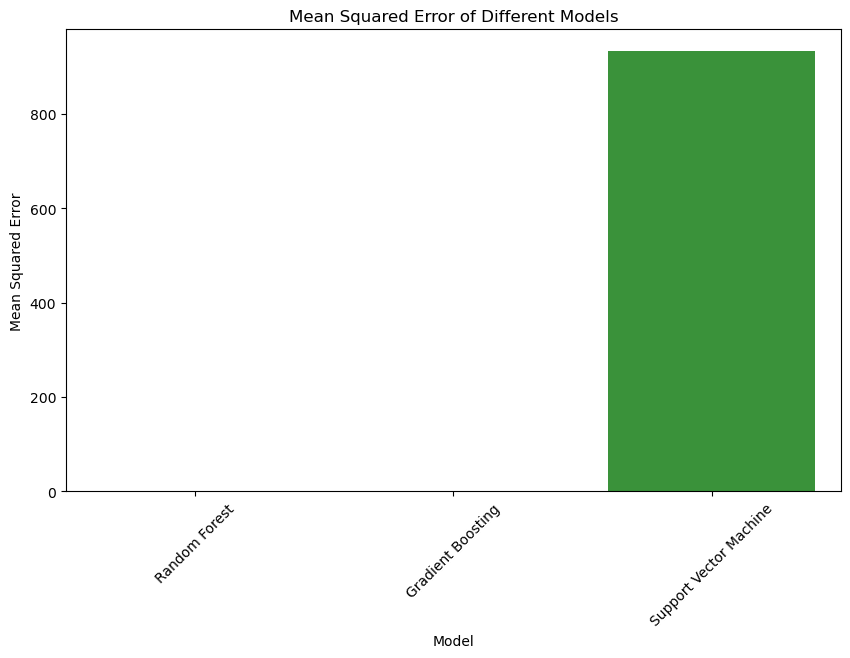

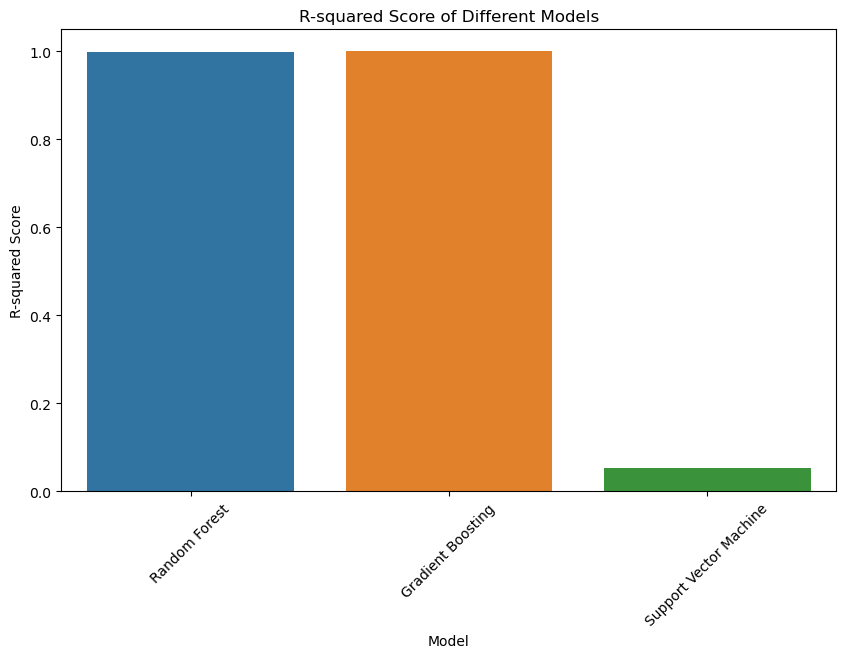

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("salary_data_cleaned.csv")

# Data Preprocessing
# Drop irrelevant columns
data.drop(['Job Description'], axis=1, inplace=True)

# Handling missing values
data.dropna(inplace=True)

# Extracting minimum and maximum salary estimates from 'Salary Estimate' column
data[['Min Salary', 'Max Salary']] = data['Salary Estimate'].str.extract(r'\$(\d+)K-\$(\d+)K')

# Handling missing values in 'Min Salary' and 'Max Salary' columns
data['Min Salary'] = data['Min Salary'].fillna(data['Min Salary'].median())
data['Max Salary'] = data['Max Salary'].fillna(data['Max Salary'].median())

# Converting the extracted values to numeric data type
data['Min Salary'] = data['Min Salary'].astype(int)
data['Max Salary'] = data['Max Salary'].astype(int)

# Dropping the original 'Salary Estimate' column
data.drop(columns=['Salary Estimate'], inplace=True)

# Encoding ordinal categorical variables
ordinal_encoder = LabelEncoder()
data['Size'] = ordinal_encoder.fit_transform(data['Size'])
data['Type of ownership'] = ordinal_encoder.fit_transform(data['Type of ownership'])
data['Revenue'] = ordinal_encoder.fit_transform(data['Revenue'])

# One-hot encoding for nominal categorical variables
nominal_cols = ['Job Title', 'Company Name', 'Location', 'Headquarters', 'Industry', 'Sector', 'Competitors', 'company_txt', 'job_state']
data = pd.get_dummies(data, columns=nominal_cols)

# Splitting data into features and target variable
X = data.drop(columns=['Min Salary', 'Max Salary'])  # Dropping the salary columns from features
y = data['Min Salary']  # Assuming we use 'Min Salary' as the target variable

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training various machine learning models
models = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Machine": SVR()
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R^2': r2}

# Displaying results
for name, result in results.items():
    print(f"{name}:")
    print(f"MSE: {result['MSE']}")
    print(f"R^2: {result['R^2']}")
    print()

# Visualizing results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=[result['MSE'] for result in results.values()])
plt.title('Mean Squared Error of Different Models')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=[result['R^2'] for result in results.values()])
plt.title('R-squared Score of Different Models')
plt.xlabel('Model')
plt.ylabel('R-squared Score')
plt.xticks(rotation=45)
plt.show()


In [38]:
# Download required nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load the dataset
data = pd.read_csv("salary_data_cleaned.csv")

# Extracting minimum and maximum salary estimates from 'Salary Estimate' column
data[['Min Salary', 'Max Salary']] = data['Salary Estimate'].str.extract(r'\$(\d+)K-\$(\d+)K')

# Handling missing values in 'Min Salary' and 'Max Salary' columns
data['Min Salary'] = data['Min Salary'].fillna(data['Min Salary'].median())
data['Max Salary'] = data['Max Salary'].fillna(data['Max Salary'].median())

# Converting the extracted values to numeric data type
data['Min Salary'] = data['Min Salary'].astype(int)
data['Max Salary'] = data['Max Salary'].astype(int)

# Dropping the original 'Salary Estimate' column
data.drop(columns=['Salary Estimate'], inplace=True)

# Text Preprocessing
job_descriptions = data['Job Description'].fillna('')  # Handle missing values

# Function for text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply text preprocessing to job descriptions
job_descriptions_preprocessed = job_descriptions.apply(preprocess_text)

# Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(job_descriptions_preprocessed)

# Statistical Analysis
model = LinearRegression()
model.fit(X, data['Min Salary'])  # Using 'Min Salary' as the target variable
coefficients = pd.Series(model.coef_, index=tfidf_vectorizer.get_feature_names())

# Visualize the coefficients or perform further analysis as needed
print(coefficients.nlargest(10))  # Print top 10 words with the highest coefficients


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dawsonburgess/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dawsonburgess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dawsonburgess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/dawsonburgess/nltk_data...


senior          758.651511
five            134.282064
control         122.029159
view            114.347030
prior           106.810271
release         105.544358
platform        103.974613
principal       103.915949
optimization    103.749594
mentor          103.627288
dtype: float64


/Users/dawsonburgess/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
